In [1]:
import cv2
import mediapipe as mp
import urllib.request as urlreq
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Rectangle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob
import pandas as pd

#from rembg import remove

from config import *
from cropping import *
from landmarks_utils import *
from preprocessing import *
from face_landmarking_model import *
from training import *
from face_dataset import FaceDataset, EnsembleSampler
import itertools

In [2]:
# Prepare best groups for ensemble projection
groups = [os.path.basename(os.path.normpath(path_string)) for path_string in glob("./AI_Morphometrics/*/", recursive = False)]
groups_results = pd.read_json('training_results_means.json', orient='index')
groups_results.columns = ['result']
list_df = pd.read_csv('./preprocessed_data/path_list.txt', names=['text'], header=None)
counts = {}
for group in groups:
    counts[group] = len(list_df[list_df['text'].str.contains(group)])
compare = pd.concat([groups_results, pd.DataFrame(counts.items(), columns=['group', 'sample']).set_index('group')], axis = 1)
#plt.scatter(x=compare['sample'], y=compare['result'])

best_groups = compare.dropna().sort_values(by=['sample']).sort_values(by=['result']).index.to_list()

In [3]:
results = {}
valid_results = {}
cached_models = {}
times = {}
projectors = [1]
rotations = [True]
learning_rates = [0.01]
hidden_head_index = [3]
num_parents = [5]
ffn_bias = [False]

hyperparameter_combinations = list(itertools.product(projectors, rotations, learning_rates, num_parents, hidden_head_index, ffn_bias))
i = 0
for num_projectors, rotate, lr, num_parent_landmarks, hidden_head_index, ffn_bias in tqdm(hyperparameter_combinations):
    combination = f"{num_projectors}_{rotate}_{lr}_{num_parent_landmarks}_{hidden_head_index}_{ffn_bias}"
    model, optimizers, schedulers, datasets, dataloaders = prepare_trainers(best_groups, 
                                                                            num_parent_landmarks = num_parent_landmarks, 
                                                                            projectors=num_projectors, 
                                                                            rotate=rotate, 
                                                                            lr_projection=0.01,
                                                                            lr_cnn=0.01,
                                                                            lr_ffn=0.0001,
                                                                            hidden_head_index=hidden_head_index,
                                                                            ffn_bias=ffn_bias,
                                                                            template_size=50
                                                                            )

            

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


In [4]:
dataset = datasets['main']
dataset.work = True

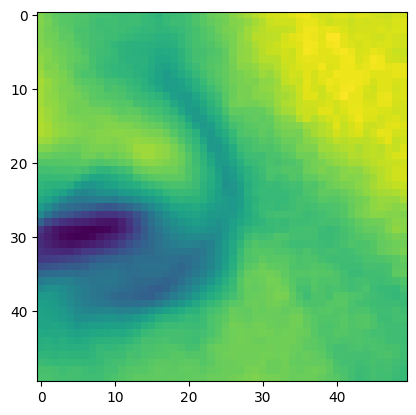

In [11]:
plt.imshow(dataset.template[15])

In [12]:
def image_template_matching(image, avg_template):
    template_method = eval(['cv2.TM_CCORR','cv2.TM_CCORR_NORMED'][1])
    match = cv2.matchTemplate(image, avg_template, template_method)
    return match

tensor([4333])


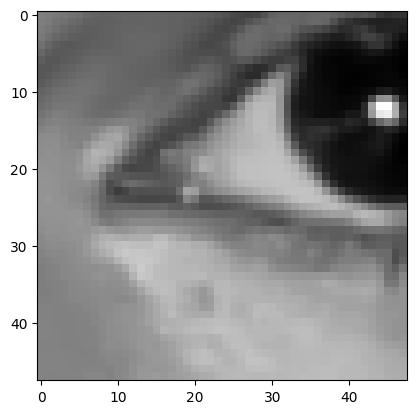

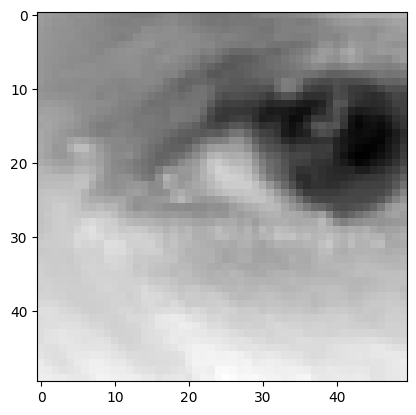

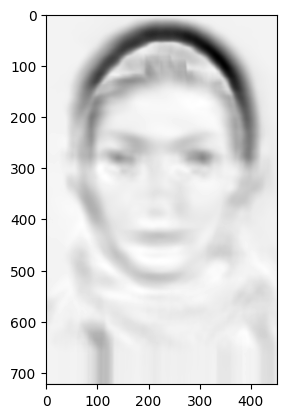

In [44]:
dataset.pretraining = False
idx = torch.randint(dataset.__len__(),(1,))
print(idx)
batch = dataset.__getitem__(idx)
inputs, targets, multicrop, subimage, image = batch
templates = dataset.template.numpy()
subimage = subimage.squeeze().astype(np.float32)
# landmark = 0
landmark +=1
plt.imshow(multicrop[landmark], cmap = 'gray')
plt.show()
plt.imshow(templates[landmark], cmap = 'gray')
plt.show()
plt.imshow(image_template_matching(subimage, templates[landmark]), cmap = 'gray')
#plt.imshow(image_template_matching(subimage, multicrop[landmark].numpy().squeeze().astype(np.float32)), cmap = 'gray')
# plt.imshow(image_template_matching(templates[landmark],multicrop[landmark].numpy().squeeze().astype(np.float32)), cmap = 'gray')
# plt.imshow(get_image_edges(normalize_colors(subimage)))
# plt.show()
# plt.imshow(get_image_edges(cv2.cvtColor(subimage, cv2.COLOR_BGR2GRAY)))
# plt.show()
#display_landmarks(inputs.reshape(-1,2)[:478,:], subimage, origin = 'upper_left')

53.35358570663567


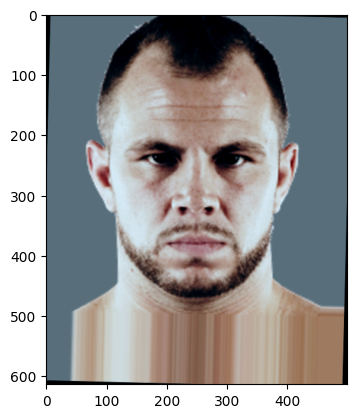

In [62]:
def normalize_colors(image):
    # Convert BGR to LAB color space
    print(np.std(image[:,:,2]))
    lab_image = image.copy()
        
    # lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    lab_image[:, :, 0] = np.clip(128 + (lab_image[:, :, 0] - np.mean(lab_image[:, :, 0])),0,255)
    lab_image[:, :, 1] = np.clip(128 + (lab_image[:, :, 1] - np.mean(lab_image[:, :, 1])),0,255)
    lab_image[:, :, 2] = np.clip(128 + (lab_image[:, :, 2] - np.mean(lab_image[:, :, 2])),0,255)

    return lab_image

plt.imshow(normalize_colors(subimage))

[154, 266]


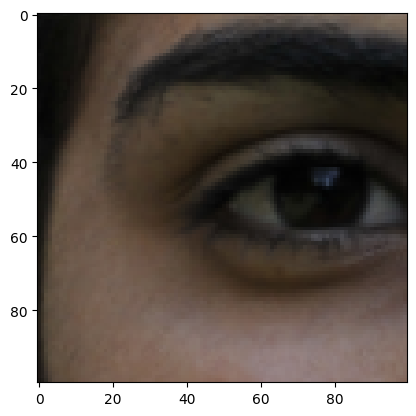

In [ ]:
landmark_num = 20
image = subimage
targets = targets.reshape(-1,2)
crop_pixel_center = [int(targets[landmark_num,0].item() * image.shape[1]), int(targets[landmark_num,1].item() * image.shape[0])]
print(crop_pixel_center)
crop_size = 100
crop = image[crop_pixel_center[1] - crop_size//2: crop_pixel_center[1] + crop_size//2, crop_pixel_center[0] - crop_size//2: crop_pixel_center[0] + crop_size//2,:]
plt.imshow(crop)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class LandmarkLocalizationMobileNetV2(nn.Module):
    def __init__(self, num_landmarks):
        super(LandmarkLocalizationMobileNetV2, self).__init__()

        # Use MobileNetV2 as the backbone
        self.backbone = models.mobilenet_v2(pretrained=True)
        #self.backbone = nn.Sequential(*list(backbone.children())[:-2])

        # Modify the output layer to match the number of landmarks
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(in_features, num_landmarks * 2)

    def forward(self, x):
        # Forward pass through the network
        x = self.backbone.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).reshape(x.shape[0], -1)
        landmarks = self.backbone.classifier(x)
        return landmarks

# Example usage
num_landmarks = 72  # Adjust based on the number of landmarks you're detecting
model = LandmarkLocalizationMobileNetV2(num_landmarks)

c:\Users\jtrnka\Documents\GitHub\Face-Landmarking\Face-Landmarking\face_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jtrnka\Documents\GitHub\Face-Landmarking\Face-Landmarking\face_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 10  # Adjust based on your requirements
criterion = nn.MSELoss()  # Mean Squared Error loss for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)


for epoch in range(num_epochs):
    model.train()

    for i, batch in enumerate(dataloader):
        x, y, template_match, subimage = batch

        # Forward pass
        outputs = model(subimage)
        loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch},{i + 1}], Loss: {loss.item()}', end='\r')

RuntimeError: stack expects each tensor to be equal size, but got [674, 500, 3] at entry 0 and [630, 500, 3] at entry 1

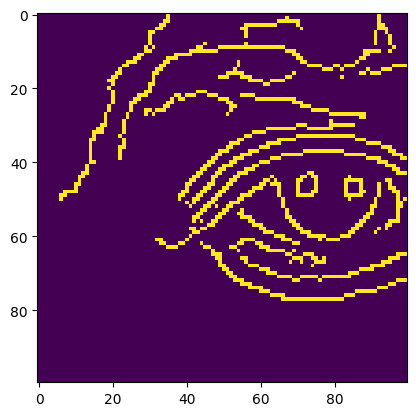

(100, 100)


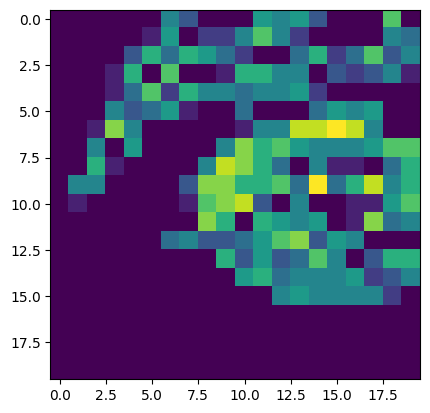

In [ ]:
edges = get_edges(crop)
plt.imshow(edges)
plt.show()
print(edges.shape)
m = nn.MaxPool2d(3, stride=3)
#avg_edges = m(torch.from_numpy(edges).unsqueeze(0)/255)
avg_edges = F.avg_pool2d(torch.from_numpy(edges).unsqueeze(0).unsqueeze(0)/255, kernel_size=5)
plt.imshow(avg_edges.squeeze().numpy()[:,:,None])
plt.show()

In [ ]:
def get_edges(image, threshold1=50, threshold2=150):
    img_blur = cv2.GaussianBlur(image, (3,3), 5) 
    edges = cv2.Canny(image=img_blur, threshold1=threshold1, threshold2=threshold2) 
    return edges
    


# sharpen_kernel = np.array([[-1, -1, -1],
#                            [-1, 9, -1],
#                            [-1, -1, -1]])  # Sharpening kernel
# sharpened_image = cv2.filter2D(crop, -1, sharpen_kernel)
# plt.imshow(sharpened_image)

landmark_num = 20

idx = torch.randint(dataset.__len__(),(1,))
print(idx)
#idx = 506
batch = dataset.__getitem__(idx)
inputs, targets, _, subimage, image = batch
y = targets.reshape(-1,2)

#display_landmarks(y[landmark_num:landmark_num+1,:], image, origin='upper_left')

# crop_pixel_center = [int(y[landmark_num,0].item() * image.shape[1]), int(y[landmark_num,1].item() * image.shape[0])]
# crop_size = 100
# crop = image[crop_pixel_center[1] - crop_size//2: crop_pixel_center[1] + crop_size//2, crop_pixel_center[0] - crop_size//2: crop_pixel_center[0] + crop_size//2,:]

img_blur = cv2.GaussianBlur(subimage, (3,3), 5) 
#plt.imshow(img_blur) 

# sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
# sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
# sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
# plt.imshow(sobelxy)
 
# #Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=50, threshold2=150) 
plt.imshow(edges)

image = edges.copy()

tensor([317])


ValueError: not enough values to unpack (expected 5, got 3)

In [ ]:
# making average multicrop
# preparation dataset
def get_avg_template(prep_dataset, template_size):
    multicrops = []
    for i in range(200):
        idx = torch.randint(prep_dataset.__len__(),(1,))
        batch = prep_dataset.__getitem__(idx)
        _, targets, _, subimage, image = batch
        img_blur = cv2.GaussianBlur(subimage, (3,3), 5) 
        edges = cv2.Canny(image=img_blur, threshold1=50, threshold2=150) 
        image = torch.from_numpy(edges).unsqueeze(-1)
        multicrop = make_landmark_crops(targets.reshape(1,-1), image, template_size)
        multicrops.append(multicrop)

    return torch.mean(torch.stack(multicrops, dim=0), dim=0)

avg_multicrop = get_avg_template(dataset, 30)


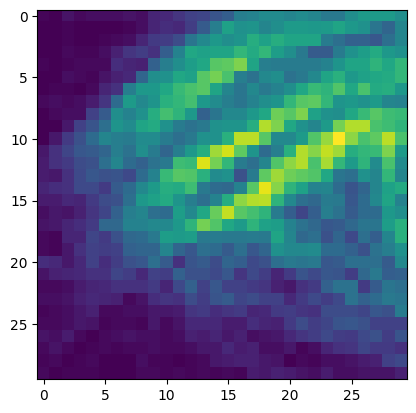

In [ ]:
plt.imshow(avg_multicrop[landmark_num,:,:])

In [ ]:
from cropping import make_landmark_crops
#image = torch.from_numpy(edges).unsqueeze(-1)
multicrop = make_landmark_crops(y.reshape(1,-1), image, 30)
num_landmark = 0


tensor([[0.5113, 0.1693, 0.4981, 0.7453, 0.4952, 0.6525, 0.5593, 0.6367, 0.4411,
         0.6346, 0.6181, 0.6154, 0.3870, 0.6101, 0.4934, 0.5881, 0.5220, 0.5829,
         0.4704, 0.5814, 0.5708, 0.5964, 0.4267, 0.5930, 0.4886, 0.5422, 0.5256,
         0.5207, 0.4535, 0.5201, 0.5731, 0.5233, 0.4195, 0.5220, 0.4335, 0.4894,
         0.5504, 0.4904, 0.4278, 0.4097, 0.3233, 0.3968, 0.3765, 0.3809, 0.3748,
         0.4092, 0.3533, 0.3894, 0.3982, 0.3898, 0.4115, 0.4117, 0.5706, 0.4098,
         0.6809, 0.3955, 0.6318, 0.4071, 0.6321, 0.3809, 0.6551, 0.3899, 0.6103,
         0.3895, 0.5951, 0.4079, 0.2599, 0.3591, 0.4422, 0.3542, 0.7521, 0.3558,
         0.5619, 0.3487, 0.5976, 0.3228, 0.6601, 0.3201, 0.7157, 0.3326, 0.6055,
         0.3360, 0.6559, 0.3320, 0.7088, 0.3412, 0.2929, 0.3321, 0.3515, 0.3228,
         0.4126, 0.3299, 0.3009, 0.3420, 0.3500, 0.3359, 0.4002, 0.3418, 0.2222,
         0.4352, 0.2325, 0.4800, 0.2413, 0.5270, 0.2489, 0.5740, 0.2578, 0.6188,
         0.2871, 0.6616, 0.3

UnboundLocalError: cannot access local variable 'multicrop' where it is not associated with a value

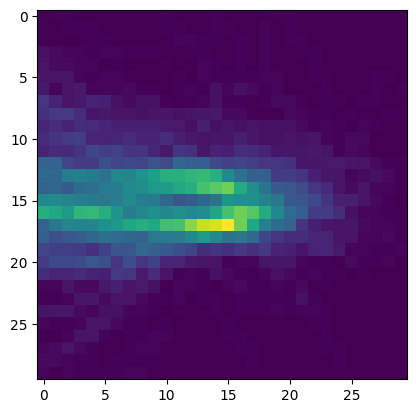

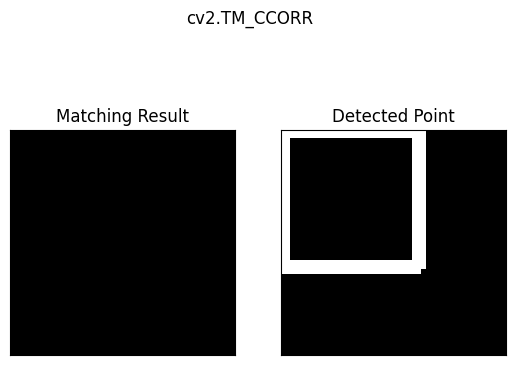

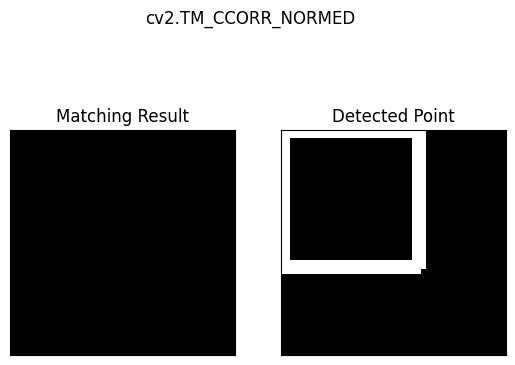

In [ ]:
#num_landmark=0
multicrop = avg_multicrop
channels = int(multicrop.shape[0]/72)
num_landmark+=1

landmarks = (int(y[num_landmark,0] * image.shape[1]), int(y[num_landmark,1] * image.shape[0]))

subimage = image[landmarks[1]-25 : landmarks[1]+25, landmarks[0]-25:landmarks[0]+25].astype(np.uint8)
landmark_pattern = multicrop[channels*num_landmark:channels*(num_landmark+1)].permute(1,2,0).squeeze().numpy().astype(np.uint8)

plt.imshow(landmark_pattern)
plt.show()
w, h = landmark_pattern.shape[1], landmark_pattern.shape[0]

methods = ['cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED']
for meth in methods:
    img = subimage.copy()
    method = eval(meth)
    # Apply template Matching
    template = landmark_pattern
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

In [ ]:
res.shape

(21, 21)

In [ ]:

def template_matching(image, landmarks, avg_template, crop_size = 50, template_method = None):
    method = eval(template_method)
    multicrop = make_landmark_crops(landmarks.reshape(1,-1), image, crop_size)
    crops = torch.split(multicrop, split_size_or_sections=1, dim=0)
    templates = torch.split(avg_template, split_size_or_sections=1, dim=0)
    matches = np.empty([1,0])

    for crop, template in zip(crops, templates):
        match = cv2.matchTemplate(crop, template, method)
        matches = np.concatenate([matches, match.reshape(1,-1)], axis= 1)
        
    return torch.from_numpy(matches).to(DEVICE)

In [ ]:
matching = np.empty([1,0])
matching 

array([], shape=(1, 0), dtype=float64)

In [ ]:
matching = np.concatenate([matching, res.reshape(1,-1)], axis= 1)
matching.shape

(1, 2205)

In [ ]:
import numpy as np
a = np.random.randn(72,50,50)
np.split(a, indices_or_sections=a.shape[-3], axis = 0)[0].shape

(1, 50, 50)

In [ ]:
a = np.random.randn(1,50,50)
a.squeeze().shape

(50, 50)

In [ ]:
a/255

array([[[ 5.65946858e-03,  2.45189645e-03,  7.29740426e-03, ...,
          6.10436344e-03,  1.92203460e-03,  3.86222723e-03],
        [ 4.96989841e-03,  1.62462688e-03, -2.36896074e-03, ...,
         -1.36104157e-03,  4.31562049e-04,  1.33176842e-03],
        [-2.46885923e-03, -4.18366181e-03,  3.06395765e-03, ...,
          1.16829861e-03, -3.87753975e-04,  5.35964640e-04],
        ...,
        [-2.90575505e-03, -3.54442885e-03, -7.39694657e-03, ...,
         -1.77515915e-03, -2.16126390e-03,  9.07595725e-05],
        [ 6.92978039e-03,  9.00776874e-04, -3.08878657e-03, ...,
          1.96419018e-03,  3.22857210e-03,  5.17854514e-03],
        [-4.68027773e-03, -4.00276969e-03, -3.35352690e-03, ...,
          2.54522072e-04,  8.86141244e-04, -2.13434246e-03]]])

In [4]:
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import euclidean_distances
import cv2

from landmarks_utils import *
from cropping import *
from config import *
from face_landmarking_model import *
from face_dataset import *
from training import create_projection_mask, create_template_mask

num_parent_landmarks = 5 
projectors=1
rotate=True
lr_projection=0.01
lr_cnn=0.01
lr_ffn=0.01
hidden_head_index=2
ffn_bias=False
template_size=30
    
projection_mask = create_projection_mask(num_parent_landamrks=num_parent_landmarks)
template_mask = create_template_mask(template_size)    


model = FaceLandmarking(projection_mask, template_mask, projectors=projectors, hidden_head_index=hidden_head_index, ffn_bias=ffn_bias).to(DEVICE)
preparation_dataset = FaceDataset(model=model, rotate=rotate, subgroups=best_groups[:15])
avg_template = get_avg_template(preparation_dataset, template_size)
main_dataset = FaceDataset(model, rotate=rotate, avg_template=avg_template)

Average template construction failed!


In [ ]:
main_dataset.pretraining = False
idx = torch.randint(main_dataset.__len__(),(1,))
print(idx)
#idx = 165

batch = main_dataset.__getitem__(idx)
inputs, targets, template= batch

tensor([207])


In [ ]:
templates = template.reshape(72,-1)
templates.shape

torch.Size([72, 441])

In [ ]:
templates = torch.split(template, split_size_or_sections=441, dim = 0)
len(templates)

72

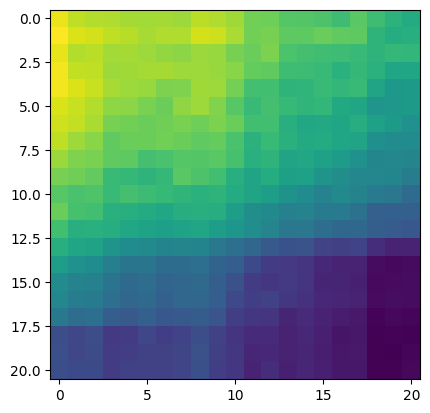

In [ ]:
plt.imshow(templates[20,:].reshape(21,21))